With the dataset (https://pypi.org/project/python-mnist/)

Create custom class with any quantity of layers:

Input: any shape 

Hidden: any quantity, any shape

Output: any shape

Answer of the model is number from 0 to 9 or nan for pictures whis model could not recognize

Loss: you can choose categorical or binary cross entropy

Activation functions: sigmoid, tanh, relu, softmax

Optimizer: SGD, SGD + momentum, Nesterov, AdaGrad, RMSprop

Stack: python, numpy, matplotlib

In [1]:
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
from numpy import inf

In [2]:
from mnist import MNIST
mndata = MNIST('./mnist/')
images, labels = mndata.load_training()

In [3]:
# i need to limit numbers of data
images, labels = images[:1000], labels[:1000]

Exceptions

In [4]:
class SizeError(Exception):
    pass

class ShapeError(Exception):
    pass

class ValSizeError(Exception):
    pass

class LayerSizeError(Exception):
    pass

class DataShapeError(Exception):
    pass

class UnknownOptimizerError(Exception):
    pass

class UnknownActivationFuncError(Exception):
    pass

class UnknownLossFunction(Exception):
    pass

class ActivationOutputError(Exception):
    pass

In [5]:
data = np.array(images).astype('float64')
labels = np.array(labels)

In [6]:
data.shape, labels.shape

((1000, 784), (1000,))

Shape of data set and labels are similar as in preview discription

Lets look on first 10 images and try to recognise them with our own eyes

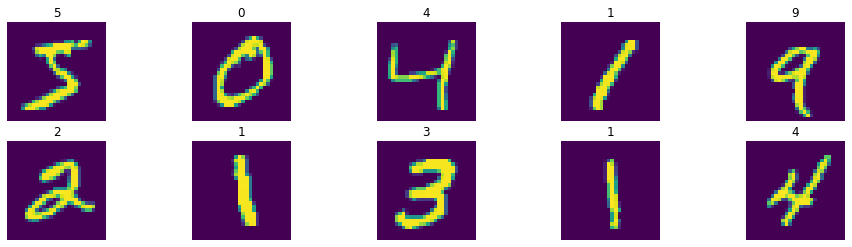

In [7]:
fig = plt.figure(figsize=(16, 4))

for el in range(10):
                        
    fig.add_subplot(2, 5, el+1)
    plt.axis('off')
    plt.imshow(data[el].reshape(28,28), interpolation='nearest')
    plt.title(labels[el])
    
plt.show()    

Easily regnose, so try to teach our machine to see this numbers

Our labels are number we need to convert them into array with 1 for our label and with zeros for other labels.
For 5 it will be [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]. Last 0 for nan value

So we need specific class Labler

In [8]:
class Labler(object):

    def __init__(self):
        pass

    def fit(self, labels):
        
        self.classes = np.unique(labels)
        return self
        
    def transform(self, labels):
        
        zero_list = np.zeros((labels.shape[0], self.classes.shape[0] + 1))

        for label, el in zip(labels, range(labels.shape[0])):
            zero_list[el][label] = 1
              
        return zero_list    

In [9]:
labeler = Labler()
y = labeler.fit(labels).transform(labels)

Now with the help of numpy we invent custom class of NN

In [10]:
class Custom(object):

    def __init__(self):
        pass
    model_with_layer = False
    
    def validation_split(self, X, y, size=0.3):

        if size == None:
            raise ValSizeError('You need to input size of validation data')
        # specify size of val score in range (0, 1)
        elif 1 < size or size < 0:
            raise SizeError('Size must be in range (0, 1)')
        # check shapes of our input values X and y
        elif X.shape[0] != y.shape[0]:
            raise ShapeError("Shape of your data doesn't fit to each other X = ({0},), y = ({1},)".format(
                X.shape[0], y.shape[0]))
        else:
            # make mask for spliting our X by indexes on train and val
            mask = np.random.rand(len(X)) <= (1 - size)
            # train split
            X_train = X[mask]
            y_train = y[mask]
            # shuffle our train_data
            shuffler = np.random.permutation(len(X_train))
            X_train = X_train[shuffler]
            y_train = y_train[shuffler]
            # validation split
            X_val = X[~mask]
            y_val = y[~mask]
            # shuffle our validation_data
            shuffler = np.random.permutation(len(X_val))
            X_val = X_val[shuffler]
            y_val = y_val[shuffler]

        return X_train, X_val, y_train, y_val

    def input_normal(self, X):
        # normalization = (p - min) / (max - min)
        normalized_data = (X - np.min(X)) / (np.max(X) - np.min(X))
        return normalized_data

    def relu(self, X):
        # relu function
        relu = np.maximum(0, X)
        return relu

    def relu_der(self, X):
        # derivative relu function
        X[X <= 0] = 0
        X[X > 0] = 1
        return X

    def softmax(self, X):
        # softmax function
        exps = np.exp(X - X.max())
        return exps / np.sum(exps, axis=0)

    def softmax_der(self, X):
        # derivative softmax function
        exps = np.exp(X - X.max())
        softmax = exps / np.sum(exps, axis=0)
        return softmax * (1 - softmax)

    def sigmoid(self, X):
        # sigmoid function
        sigm = 1 / (1 + np.exp(-X))
        return sigm
    
    def sigmoid_der(self, X):
        # derivative sigmoid sunction
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def tanh(self, X):
        # tanh function
        return np.tanh(X)

    def tanh_der(self, X):
        # derivative tanh function
        return 1 - X ** 2

    def leaky_relu(self, X):
        # leaky relu function
        l_relu = np.maximum(0, X)
        return l_relu

    def leaky_relu_der(self, X):
        # derivative leaky relu function
        X[X <= 0] = 0.001
        X[X > 0] = 1
        return X

    def layer(self, size=None, activation='relu'):
        # for adding specific layer with activation function in model
        if not size:
            raise LayerSizeError('You should input specific size for layer')
        if self.model_with_layer == False:
            self.model_with_layer = {'size': [], 
                                     'activation': []}
            self.model_with_layer['size'].append(size)
            self.model_with_layer['activation'].append(activation)
        else:
            self.model_with_layer['size'].append(size)
            self.model_with_layer['activation'].append(activation)  
        return self

    def sgd_opt(self, gradient, lr=0.01):
        # SGD optimizer
        return  0, lr * gradient
    
    def sgd_momentum_opt(self, gradient, lr=0.01, gamma=0.9, new_velocity=0):
        # SGD with momentum optimizer
        new_velocity = gamma * new_velocity + lr * gradient
        return 0, new_velocity

    def nag_opt(self, gradient, lr=0.01, gamma=0.9, new_velocity=0):
        # Nesterov optimizer
        old_velocity = new_velocity
        new_velocity = gamma * new_velocity + lr * gradient
        changer = gamma * (new_velocity - old_velocity ) +  new_velocity
        return new_velocity, changer

    def adagrad_opt(self, gradient, lr=0.01, grad_sq=0):
        # AdaGrad optimizer
        grad_sq = grad_sq + gradient ** 2
        changer = lr * gradient / ((grad_sq + 1e-7) ** (1/2))
        return grad_sq, changer
    
    def rmsprop_opt(self, gradient, lr=0.01, gamma=0.9, grad_sq=0):
        # RMSProp optimizer
        grad_sq = grad_sq
        grad_sq = gamma * grad_sq + (1 - gamma) * gradient ** 2
        changer = lr * gradient / ((grad_sq + 1e-7) ** (1/2))
        return grad_sq, changer

    def categorical_cross_entropy(self, y_pred, y_true):
        # our target looks like [0, 1, 0]
        # for example 0 for cat, 1 for dog, 2 for cow, 3 for bat and etc
        # prediction looks like [0.1, 0.8, 0.1] so we just multipy them
        # and after that get sum() of log we get our entropy 
        categorization = y_pred * y_true
        cat_log = - np.log(categorization)
        cat_log[cat_log == -inf] = 0
        cat_log[cat_log == inf] = 0
        cce = sum(sum(cat_log)) / cat_log.shape[0]
        return cce

    def binary_cross_entropy(self, y_pred, y_true):
        # our target looks like binary class 0 or 1, for example 0 for cat and 1 for dog
        shape = y_true.shape[1]
        cost = -1 / shape * np.sum(np.multiply(y_true, np.log(y_pred)) + np.multiply((1 - y_true), np.log(1 - y_pred)))
        bce = np.squeeze(cost)
        return bce

    def select_loss(self, y_pred, y_true, loss='binary', output_activation='sigmoid'):
        # loss selection function for binary or categorical cross entropy
        if loss == 'binary' and output_activation != 'sigmoid':
            raise ActivationOutputError('For binary cross entropy prediction should be binary class 0 or 1')
        elif loss == 'categorical' and output_activation != 'softmax':
            raise ActivationOutputError('For categorical cross entropy prediction should be in shape of unique classes of y_true')
        elif loss == 'binary':
            return self.binary_cross_entropy(y_pred, y_true)
        elif loss == 'categorical':
            return self.categorical_cross_entropy(y_pred, y_true)
        else:
            raise UnknownLossFunction('You shoul input correct loss function')

    def init_parametrs(self, nn_size):    
        # get shapes for layers
        # dict of weights
        parametrs = {}
        # initialization the weights for each layer
        for el in range(len(nn_size) - 1):
            # W weight
            parametrs['W_' + str(el)] =  np.random.randn(nn_size[el + 1], nn_size[el]) * np.sqrt(1. / nn_size[el + 1])
            # b weight
            parametrs['b_' + str(el)] =  np.zeros((nn_size[el + 1], 1))
            # velocity
            parametrs['vel_' + str(el)] = 0
        return parametrs

    def maxer(self, list_of_values):
        # function for converting prediction into labels
        max_val = 0
        i = 0
        for el_1, el_2 in enumerate(list_of_values):
            if el_2 > max_val:
                max_val = el_2
                i = el_1
        if i == 10:
            return "nan"
        else:
            return i

    def fit(self, X, y, epoch=10, gamma=0.9, lr=0.001, val_split=None, optimizer='sgd', loss='binary'):
        # function for traing our model
        # X - data
        # y - labels
        # nn_size - size of our nn by layers
        # epoch - numberf of epoch for train
        # gamma - gamma ratio for nesterov
        # val_split - size of validation data
        # nesterov - if True then use
        if len(X.shape) == 1:
            first_shape = X.shape[0]
        else:
            first_shape = X.shape[1]
        self.parametrs = self.init_parametrs([first_shape] + self.model_with_layer['size'])
        #split for train with validation data and without
        if val_split:
            # validation split
            X_train, X_val, y_train, y_val = self.validation_split(X, 
                                                                   y, 
                                                                   size=val_split)
            # lists for plot
            loss_tra_end = []
            loss_val_end = []
            #start train
            for el in range(epoch):
                
                self.train(X_train, y_train, self.parametrs, lr, gamma, optimizer, loss)
                self.train_val(X_val, y_val, self.parametrs, loss)
                loss_tra_end.append(self.train_loss)
                loss_val_end.append(self.val_loss)
                # we can print cross entropy score on each epoch
                # print('Cross_validation_score_on_train: {0}'.format(self.train_loss),
                #      'Cross_validation_score_on_validation: {0}'.format(cce_val))
        else:
            # for only data train
            loss_tra_end = []
            for el in range(epoch):
                self.train(X, y, self.parametrs, lr, gamma, optimizer)
                loss_tra_end.append(self.train_loss)
                # print('Cross_validation_score: {0}'.format(self.train_loss))
        # plot a graph of cross entropy score on each epoch
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.grid()
        ax.plot(range(epoch), loss_tra_end, label='cross_train_score')
        ax.plot(range(epoch), loss_val_end, label='cross_valid_score')
        ax.legend()

    def activation_layer(self, input_data, activation):

        if activation == 'relu':
            return self.relu(input_data)
        elif activation == 'sigmoid':
            return self.sigmoid(input_data)
        elif activation == 'softmax':
            return self.softmax(input_data)
        elif activation == 'lrelu':
            return self.leaky_relu(input_data)
        elif activation == 'tanh':
            return self.tanh(input_data)
        else:
            raise UnknownActivationFuncError('Inputed activation {0} does not supported'.format(activation))
    
    def activation_layer_derivative(self, input_data, activation):

        if activation == 'relu':
            return self.relu_der(input_data)
        elif activation == 'sigmoid':
            return self.sigmoid_der(input_data)
        elif activation == 'softmax':
            return self.softmax_der(input_data)
        elif activation == 'lrelu':
            return self.leaky_relu_der(input_data)
        elif activation == 'tanh':
            return self.tanh_der(input_data)
        else:
            raise UnknownActivationFuncError('Inputed activation {0} does not supported'.format(activation))

    def optimizer(self, input_data, need_data, lr, gamma, optimizer):
        
        if optimizer == 'sgd':
            return self.sgd_opt(gradient=input_data, lr=lr)
        elif optimizer == 'sgd_momentum':
            return self.sgd_momentum_opt(gradient=input_data, lr=lr, gamma=gamma, new_velocity=need_data)
        elif optimizer == 'nag':
            return self.nag_opt(gradient=input_data, lr=lr, gamma=gamma, new_velocity=need_data)
        elif optimizer == 'adagrad':
            return self.adagrad_opt(gradient=input_data, lr=lr, grad_sq=need_data)
        elif optimizer == 'rmsprop':
            return self.rmsprop_opt(gradient=input_data, lr=lr, gamma=gamma, grad_sq=need_data)
        else:
            raise UnknownOptimizerError('Inputed optimizer {0} does not supported'.format(optimizer))

    def forward(self, X, parametrs):
        # function for forward multipy our weights
        # firstly normilize data
        X = self.input_normal(X)
        size = len(self.model_with_layer['size']) - 1
        fun_act = self.model_with_layer['activation']
        # forward learning
        # first layer
        parametrs['l_0'] = parametrs['W_0'] @ X.T + parametrs['b_0']
        # activation function
        parametrs['l_0_out'] = self.activation_layer(parametrs['l_0'], fun_act[0])
        # every next layer
        for el in range(size):
            # out from previous is input for next parametrs['l_0_out']
            parametrs['l_' + str(el + 1)] = parametrs['W_' + str(el + 1)] @ parametrs['l_' + str(el) + '_out'] + parametrs['b_' + str(el + 1)]
            # activation function
            parametrs['l_' + str(el + 1) + '_out'] = self.activation_layer(parametrs['l_' + str(el + 1)], fun_act[el + 1])
        self.parametrs = parametrs
        return self

    def back(self, y, parametrs):
        # function for backprop erron on our weights
        size = len(self.model_with_layer['size']) - 1
        fun_act = self.model_with_layer['activation']
        # error on current layer
        number = size
        parametrs['y_error_' + str(number)] = y - parametrs['l_' + str(number) + '_out'].T
        # gradient on current layer
        parametrs['l_grad_' + str(number)] = parametrs['y_error_' + str(number)].T * \
                                                       self.activation_layer_derivative(parametrs['l_' + str(number)], 
                                                                                        fun_act[number])
        number -= 1                                                                                    
        for el in range(size - 1):
            parametrs['y_error_' + str(number)] = parametrs['l_grad_' + str(number + 1)].T.dot(parametrs['W_' + str(number + 1)])
            # gradient on current layer
            parametrs['l_grad_' + str(number)] = parametrs['y_error_' + str(number)].T * \
                                                            self.activation_layer_derivative(parametrs['l_' + str(number)], 
                                                                                            fun_act[number])
            number -=  1
        parametrs['y_error_0'] = parametrs['l_grad_1'].T.dot(parametrs['W_1'])
        parametrs['l_grad_0'] = parametrs['y_error_0'].T * self.activation_layer_derivative(parametrs['l_0'], fun_act[0])
        self.parametrs = parametrs
        return self

    def weight_update(self, X, parametrs, lr, gamma, optimizer):
        # function for weight updates with the help of choosen optimizer
        size = len(self.model_with_layer['size']) - 1
        # error on current layer
        number = size
        for el in range(size): 
            # gradient * X                                           
            parametrs['delta_' + str(number)] = parametrs['l_grad_' + str(number)] @ parametrs['l_' + str(number - 1)].T       
            parametrs['vel_' + str(number)], changer = self.optimizer(input_data=parametrs['delta_' + str(number)], 
                                                                        need_data=parametrs['vel_' + str(number)], 
                                                                        lr=lr, 
                                                                        gamma=gamma, 
                                                                        optimizer=optimizer)
            parametrs['W_' + str(number)] = parametrs['W_' + str(number)] + changer
            number -= 1
        # gradient * X                                            
        parametrs['delta_0'] = parametrs['l_grad_0'] @ X
        # optimization
        parametrs['vel_0'], changer = self.optimizer(input_data=parametrs['delta_0'], 
                                                        need_data=parametrs['vel_0'], 
                                                        lr=lr, 
                                                        gamma=gamma, 
                                                        optimizer=optimizer)
        parametrs['W_0'] = parametrs['W_0'] + changer
        self.parametrs = parametrs
        return self

    def train(self, X, y, parametrs, lr, gamma, optimizer='sgd', loss='binary'):
        
        self.forward(X, parametrs)
        self.back(y, self.parametrs)
        self.weight_update(X, self.parametrs, lr, gamma, optimizer)            
        number = len(self.model_with_layer['size']) - 1        
        self.parametrs = parametrs
        last_activation = self.model_with_layer['activation'][-1]
        self.train_loss = self.select_loss(parametrs['l_' + str(number) + '_out'].T, y, loss, last_activation)
        return self
   
    def train_saved_weights(self, X, parametrs):
        # normalization of input data
        X = self.input_normal(X)
        # activation function for train validation data
        fun_act = self.model_with_layer['activation']
        # first layer with saved 'W' and 'b' weights
        parametrs['val_l_0'] = parametrs['W_0'] @ X.T + parametrs['b_0']
        # first layer activation out
        parametrs['val_l_out_0'] = self.activation_layer((parametrs['val_l_0']), fun_act[0])
        # quantity of all nest layers
        number = len(fun_act)
        for el in range(1, number):
            parametrs['val_l_' + str(el)] = parametrs['W_' + str(el)] @ parametrs['val_l_out_' + str(el - 1)] + parametrs['b_' + str(el)]
            parametrs['val_l_out_' + str(el)] = self.activation_layer((parametrs['val_l_' + str(el)]), fun_act[el])
        output = parametrs['val_l_out_' + str(el)]
        return output
     
    def train_val(self, X, y, parametrs, loss='binary'):
        # train validation split on saved weights
        output = self.train_saved_weights(X, parametrs)
        last_activation = self.model_with_layer['activation'][-1]
        self.val_loss = self.select_loss(output.T, y, loss, last_activation)
        return self


    def predict(self, X):
        # function for prediction on trained model with specific weights
        if len(X.shape) == 1:
            X = X.reshape((1, X.shape[0]))
            output = self.train_saved_weights(X, self.parametrs)
            maxer_1 = self.maxer(output.T[0])
        else:
            output = self.train_saved_weights(X, self.parametrs)
            maxer_1 = [self.maxer(output.T[el]) for el in range(output.T.shape[0])]
        return maxer_1

C:\Users\CHECHU~1\AppData\Local\Temp/ipykernel_6208/3424908800.py:142: RuntimeWarning: divide by zero encountered in log
  cat_log = - np.log(categorization)


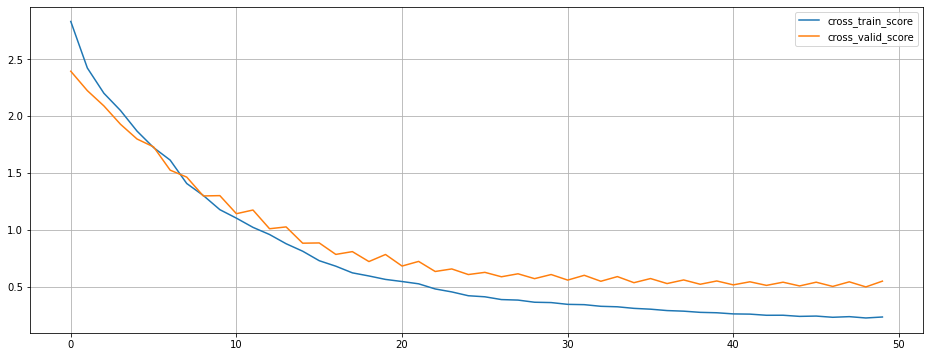

In [11]:
model = Custom()
model.layer(512, 'relu')
model.layer(256, 'relu')
model.layer(128, 'relu')
model.layer(64, 'relu')
model.layer(11, 'softmax')
model.fit(X=data, y=y, epoch=50, gamma=0.9, lr=0.001, val_split=0.3, optimizer='adagrad', loss='categorical')

In [12]:
model.predict(data[0])

5

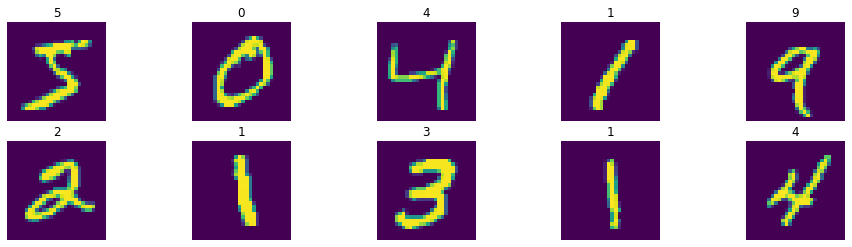

In [13]:
number = 10
fig = plt.figure(figsize=(16, 4)) #number // 5 * 4))

for el in range(number):
                        
    fig.add_subplot(2, 5, el+1) # number // 5
    plt.axis('off')
    plt.imshow(data[el].reshape(28,28), interpolation='nearest')
    plt.title(model.predict(data[el]))
    
plt.show() 

Now create custom metric for understandic of accuracy of our model

In [14]:
class Metric(object):

    def __init__(self):
        pass

    def accuracy(self, y_pred, y_true):

        return sum(y_pred == y_true) / len(y_true)

In [15]:
metric = Metric()
metric.accuracy(model.predict(data), labels)

0.931